In [2]:
import cv2  # For image processing
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For showing images

# Show an image
def printimg(image):
    # Convert the image to RGB and display it
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Remove the axes
    plt.axis('off')


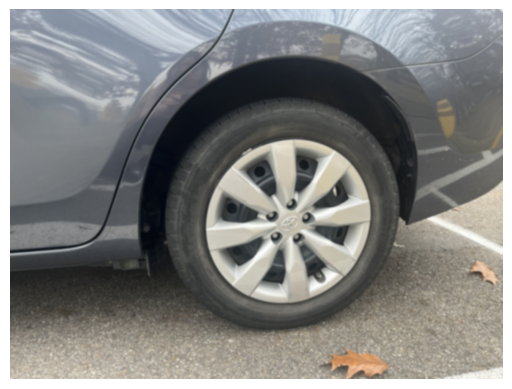

In [3]:
# Read the image from the file
image = cv2.imread('img/rgb/normal1000.jpg')

# Apply Gaussian blur to smooth the image
blurred = cv2.GaussianBlur(image, (7, 7), 0)

# Show the blurred image
printimg(blurred)


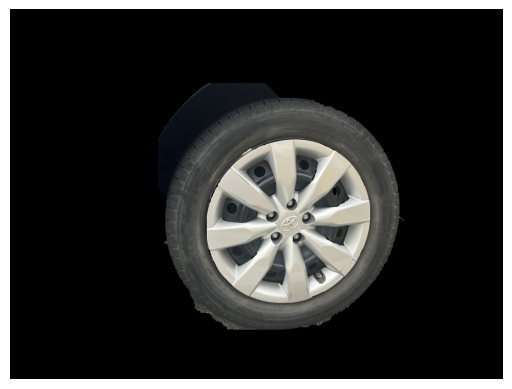

In [4]:
# Define a rectangle for the region of interest
height = image.shape[0]  # Get the height of the image
width = image.shape[1]   # Get the width of the image
rect = (300, 150, width - 500, height - 250)  # Rectangle coordinates: (x, y, width, height)

# Initialize mask and models for GrabCut
mask = np.zeros(image.shape[:2], np.uint8)  # Create a blank mask (same size as the image)
bgdModel = np.zeros((1, 65), np.float64)  # Background model (used by GrabCut)
fgdModel = np.zeros((1, 65), np.float64)  # Foreground model (used by GrabCut)

# Apply the GrabCut algorithm to segment the image
cv2.grabCut(blurred, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Create a binary mask to extract the foreground
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")  # Keep foreground pixels (1), remove background (0)
foreground = image * mask2[:, :, np.newaxis]  # Apply the mask to the original image to extract the foreground

# Show the extracted foreground
printimg(foreground)


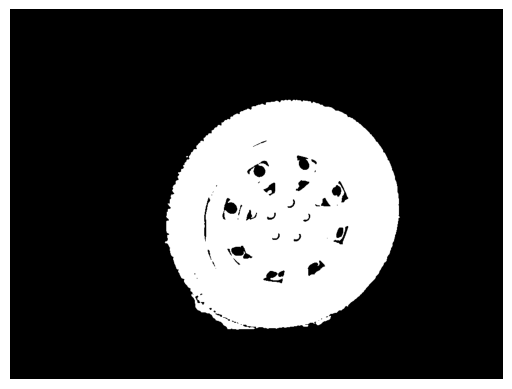

In [5]:
# Convert the foreground image to grayscale
gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image to reduce noise
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Apply binary thresholding to create a black-and-white image
# Pixels brighter than 40 are set to 255 (white), others to 0 (black)
_, dst = cv2.threshold(blurred, 52, 255, cv2.THRESH_BINARY)

# Show the thresholded image
printimg(dst)


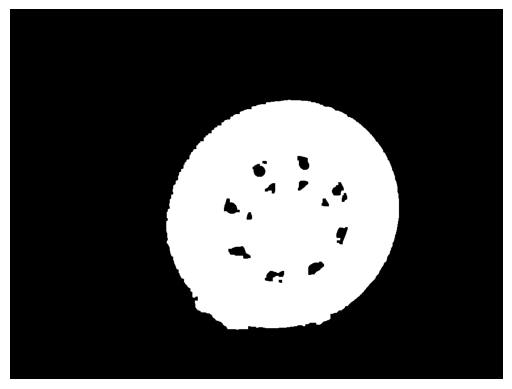

In [10]:
# Create a rectangular structuring element (kernel) for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# Make a copy of the thresholded image for processing
morph_dst = dst.copy()

# Apply morphological operations (opening and closing) 3 times
for _ in range(5):
    # Morphological opening: removes small noise (erode, then dilate)
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_OPEN, kernel,5)
    # Morphological closing: fills small holes (dilate, then erode)
    morph_dst = cv2.morphologyEx(morph_dst, cv2.MORPH_CLOSE, kernel,5)


# Show the result after morphological operations
printimg(morph_dst)


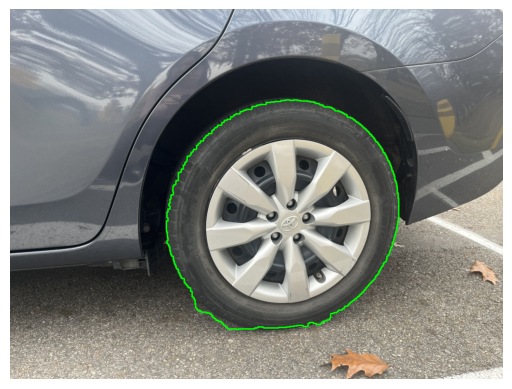

In [7]:
# Detect contours in the processed image
cont, hier = cv2.findContours(morph_dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour based on area
largest_contour = max(cont, key=cv2.contourArea)

# Create a copy of the original image to draw the contour
contoured_image = image.copy()

# Draw the largest contour on the image in green with a thickness of 2
contoured_image = cv2.drawContours(contoured_image, [largest_contour], -1, (0, 255, 0), 2)

# Show the image with the largest contour highlighted
printimg(contoured_image)


Area of symmetric difference: 3119
The tire is properly inflated


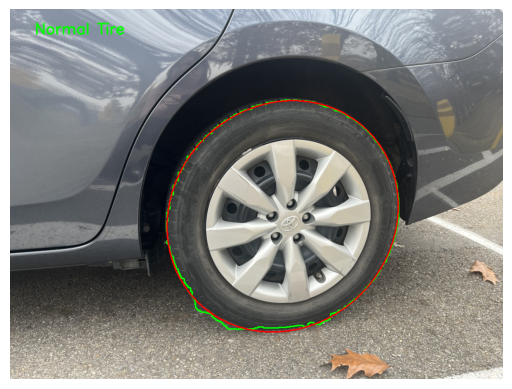

In [8]:
# Create masks the same size as the original image
mask_shape = image.shape[:2]  # Get height and width of the image
contour_mask = np.zeros(mask_shape, dtype=np.uint8)  # Mask for the contour
ellipse_mask = np.zeros(mask_shape, dtype=np.uint8)  # Mask for the ellipse

# 1. Draw the mask for the contour
cv2.drawContours(contour_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

# 2. Fit and draw an ellipse if the contour has enough points
if len(largest_contour) >= 5:  # At least 5 points are required to fit an ellipse
    min_enclosing_ellipse = cv2.fitEllipse(largest_contour)  # Fit the ellipse
    cv2.ellipse(ellipse_mask, min_enclosing_ellipse, 255, thickness=cv2.FILLED)  # Draw the ellipse

    # 3. Find the intersection and union of the contour and ellipse masks
    intersection = cv2.bitwise_and(contour_mask, ellipse_mask)  # Overlapping regions
    union = cv2.bitwise_or(contour_mask, ellipse_mask)  # Combined regions

    # Calculate the area of intersection and union
    intersection_area = np.sum(intersection == 255)  # Count white pixels in the intersection
    union_area = np.sum(union == 255)  # Count white pixels in the union

    # 4. Calculate the area of the non-overlapping regions (symmetric difference)
    symmetric_difference_area = union_area - intersection_area
    print(f"Area of symmetric difference: {symmetric_difference_area}")

    # Check if the tire might be deflated based on the area difference
    if (symmetric_difference_area / union_area) > 1 / 16:  # Threshold for deflation
        print("The tire might be deflated")
        # Add red text "flat tire" on the contoured image
        cv2.putText(contoured_image, "Flat Tire", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        print("The tire is properly inflated")
        # Add red text "normal tire" on the contoured image
        cv2.putText(contoured_image, "Normal Tire", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)


    # Draw the ellipse on the image in red
    cv2.ellipse(contoured_image, min_enclosing_ellipse, (0, 0, 255), thickness=2)

# Show the image with the contour and ellipse
printimg(contoured_image)
